In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import neurokit2 as nk
from IPython.display import display, HTML
from datetime import datetime, timezone
from pyedflib.highlevel import read_edf
from wrangle import *
import flirt
# from time_loader import *

In [36]:
required_files = [
        'CSV.csv',
        'EDF.edf'
    ]

dataDirectory = "/home/art/SignalProcessing/Sessions/exclude/P029"
participant_id = int(29)
events = "/home/art/SignalProcessing/Sessions/time_sheet1.csv"

print("Current directory is:", dataDirectory)
missing_files = [f for f in required_files if f not in os.listdir(dataDirectory)]
existing_files = [f for f in os.listdir(dataDirectory) if f in required_files]
if participant_id:
    print(f"\nChecking files for participant: {participant_id}")
    print(f"Directory being checked: {dataDirectory}")
    if not missing_files:
        print("✓ All required files are present!")
    else:
        print("\nMissing files:")
        for file in missing_files:
            print(f"✗ {file}")
        print(f"\nFound files:")
        for file in existing_files:
            print(f"• {file}")

Current directory is: /home/art/SignalProcessing/Sessions/exclude/P029

Checking files for participant: 29
Directory being checked: /home/art/SignalProcessing/Sessions/exclude/P029
✓ All required files are present!


In [37]:
hexcsv = os.path.join(dataDirectory, "CSV.csv")
hexedf = os.path.join(dataDirectory, "EDF.edf")

hextable = pd.read_csv(hexcsv)
#hextable = hextable.iloc[:, [0, 1, 2, 4, 5, 6]]                            # Keeps time, breathing, minute vent, act, HR, and cadence -AJS
#hextable = hextable.iloc[1:-1, :].reset_index(drop=True)                   # Drops first and last rows, resets index -AJS
time_start_hexo = hextable.iloc[0, 0] / 256                                # Gets start time in seconds * ( 1 / 256 as that is the sampling rate of time in csv) -AJS
startTime_hexo = datetime.fromtimestamp(time_start_hexo, tz=timezone.utc)  # Converts timestamp to datetime -AJS

signals, signal_headers, header = read_edf(hexedf)
signal_names = [header['label'] for header in signal_headers]
sampling_rates = [header['sample_frequency'] for header in signal_headers]

signal_data = {}
for i, signal_name in enumerate(signal_names):
  signal_data[signal_name] = signals[i]


max_sample_rate = max(sampling_rates)
max_sample_rate_index = sampling_rates.index(max_sample_rate)
max_sample_rate_signal_name = signal_names[max_sample_rate_index]

num_samples_max = len(signal_data[max_sample_rate_signal_name])
total_time = num_samples_max / 256
print(total_time, "seconds of Data has been loaded")
time_index = pd.date_range(start=startTime_hexo, periods=num_samples_max, freq=f'{1000/max_sample_rate}ms')

combined_raw_hexo_df = pd.DataFrame(index=time_index)

for signal_name, signal_values in signal_data.items():
  
    sample_rate = sampling_rates[signal_names.index(signal_name)]

    temp_df = pd.DataFrame({signal_name: signal_values})

    temp_time_index = pd.date_range(start = startTime_hexo, periods=len(signal_values), freq=f'{1000/sample_rate}ms')
    temp_df.index = temp_time_index

    combined_raw_hexo_df = combined_raw_hexo_df.join(temp_df, how = 'left')

ECG = signals[0] # 256 Hz
HR = signals[1] # 1 Hz
BR = signals[2] # 1 Hz

RespT = signals[3] # 128 Hz
RespA = signals[4] # 128 Hz

AccX = signals[11] # 64 Hz
AccY = signals[12] # 64 Hz
AccZ = signals[13] # 64 Hz



Resp = 13.28 * ((0.75 * RespT) + (0.25 * RespA))     # see hexoskin documentation for how this is calculated
ACC_Hex = np.sqrt((AccX**2) + (AccY**2) + (AccZ**2)) # magnitude calculation


8390.0 seconds of Data has been loaded


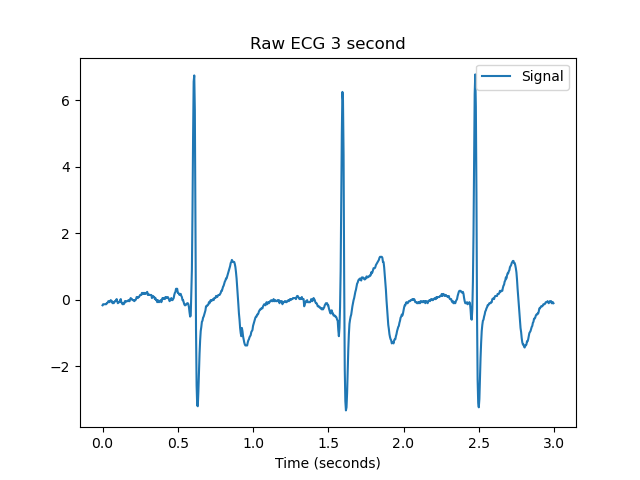

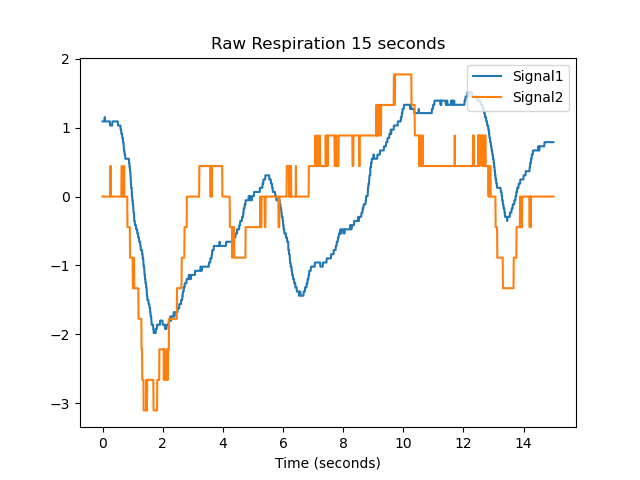

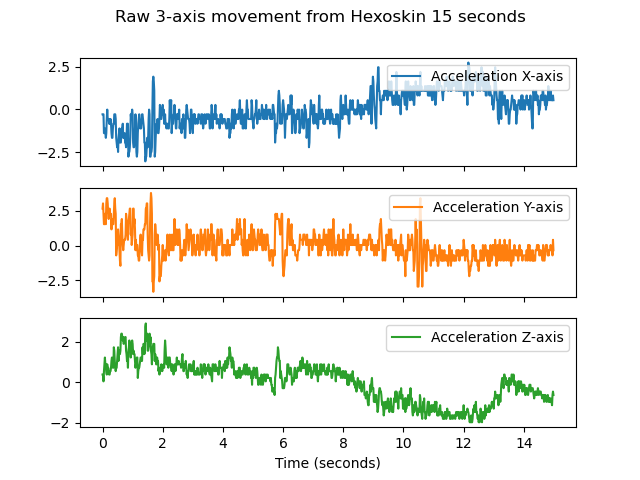

In [38]:
nk.signal_plot(ECG[460800:461568], sampling_rate=256, standardize=True) # ~ 3 second window -AJS
plt.title("Raw ECG 3 second")
nk.signal_plot([RespT[230400:232320], RespA[230400:232320]], sampling_rate=128, standardize=True) # ~ 15 second window -AJS
plt.title("Raw Respiration 15 seconds")
nk.signal_plot([AccX[115200:116160], AccY[115200:116160], AccZ[115200:116160]], sampling_rate=64,
               subplots=True, standardize=True,
               labels=["Acceleration X-axis", "Acceleration Y-axis", "Acceleration Z-axis"]) # ~ 15 second window -AJS
plt.suptitle("Raw 3-axis movement from Hexoskin 15 seconds");

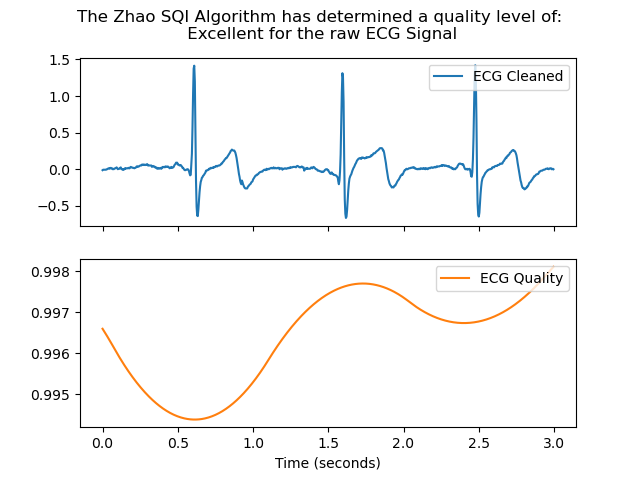

In [39]:
ecg_quality = nk.ecg_quality(ECG, sampling_rate=256, method="averageQRS")

nk.signal_plot(
    [ECG[460800:461568], ecg_quality[460800:461568]],
    sampling_rate=256,
    subplots=True,
    labels=["ECG Cleaned", "ECG Quality"],
    standardize=False
)
plt.suptitle(f"The Zhao SQI Algorithm has determined a quality level of:\n {nk.ecg_quality(ECG, sampling_rate=256, method='zhao2018', approach='fuzzy')} for the raw ECG Signal");

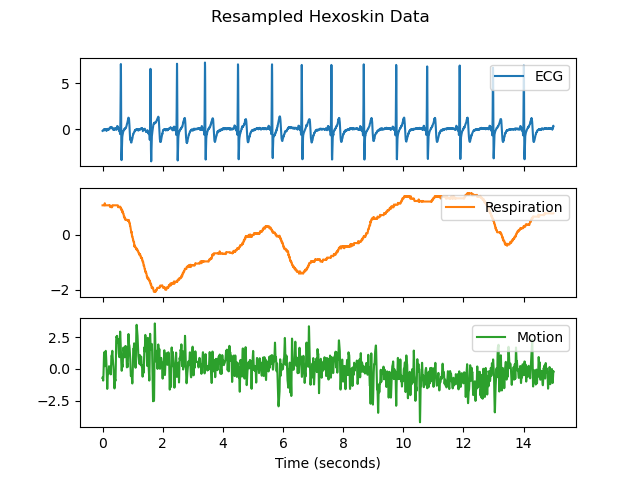

In [40]:
TARGET_SAMPLE_RATE = 256 # just in case we need to downsample instead later... -AJS
fs = TARGET_SAMPLE_RATE
ecg_up = nk.signal_resample(ECG, sampling_rate=256, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT') # already 256 -AJS

RespT_up = nk.signal_resample(RespT, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')
RespA_up = nk.signal_resample(RespA, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')
Resp_up = nk.signal_resample(Resp, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

hex_accx_up = nk.signal_resample(AccX, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_accy_up = nk.signal_resample(AccY, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_accz_up = nk.signal_resample(AccZ, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_motion_up = nk.signal_resample(ACC_Hex, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

nk.signal_plot([ecg_up[460800:464640], Resp_up[460800:464640], hex_motion_up[460800:464640]], sampling_rate=256, subplots=True, standardize=True, labels=['ECG', 'Respiration', 'Motion'])
plt.suptitle("Resampled Hexoskin Data");

In [41]:
hexo_np = np.column_stack([ecg_up, RespT_up, RespA_up, Resp_up, hex_accx_up, hex_accy_up, hex_accz_up, hex_motion_up])

time_index_hexo = pd.date_range(
    start=startTime_hexo,
    periods=len(hexo_np),
    freq=pd.Timedelta(1/fs, unit='s')
)

comb_hexo = pd.DataFrame(
    hexo_np,
    index=time_index_hexo,
    columns=["ECG","Thoratic Respiration", "Abdominal Respiration", "Combined Respiration", "ACC X", "ACC Y", "ACC Z", "Hexoskin Motion"]
)

display(comb_hexo.head())

,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2025-03-13 18:50:16+00:00,-8.69115,-8.432826e-11,-1.814220e-11,-8.428525e-10,0.070266,-0.644578,-0.820359,1.045661
2025-03-13 18:50:16.003906250+00:00,-8.70395,3.323414e+02,5.265632e+02,5.058310e+03,0.074172,-0.634812,-0.818406,1.168570
2025-03-13 18:50:16.007812500+00:00,-8.69755,-1.860703e-11,-3.516742e-11,-6.300580e-10,0.078078,-0.625047,-0.816453,1.180959
2025-03-13 18:50:16.011718750+00:00,-8.69755,-3.984498e+02,-6.961577e+02,-6.279803e+03,0.081984,-0.615281,-0.814500,1.113726
2025-03-13 18:50:16.015625+00:00,-8.69755,-2.850025e-11,-3.776213e-11,-5.088418e-10,0.085891,-0.605515,-0.812547,1.016985


In [42]:
time_data = load_event_data(events)
participant_events = select_participant(time_data, participant_id)
times, utc_times = time_extract(participant_events)

In [51]:
utc_times_df = pd.DataFrame(utc_times)
start_time = pd.to_datetime(utc_times_df['survey_start'].iloc[0]).tz_localize('UTC')
end_time = pd.to_datetime(utc_times_df['recovery_end'].iloc[0]).tz_localize('UTC')

exclude_columns = [
    "date",
    "start_time",
    "end_time",
    "participant_id",
    "total_time",
    "experimental_time",
    "arrival_time"
]

for column in utc_times_df.columns:
    if column not in exclude_columns:
        utc_times_df[column] = pd.to_datetime(utc_times_df[column]).dt.tz_localize('UTC')
        
time_periods = [
    {"name": "survey", "start": utc_times_df['survey_start'].iloc[0], "end": utc_times_df['survey_end'].iloc[0]},
    {"name": "cycle_cal", "start": utc_times_df['cycle_cal_start'].iloc[0], "end": utc_times_df['cycle_cal_end'].iloc[0]},
    {"name": "matb_train", "start": utc_times_df['matb_train_start'].iloc[0], "end": utc_times_df['matb_train_end'].iloc[0]},
    {"name": "cycle", "start": utc_times_df['cycle_start'].iloc[0], "end": utc_times_df['cycle_end'].iloc[0]},
    {"name": "rest_1", "start": utc_times_df['rest_1_start'].iloc[0], "end": utc_times_df['rest_1_end'].iloc[0]},
    {"name": "baseline", "start": utc_times_df['base_start'].iloc[0], "end": utc_times_df['base_end'].iloc[0]},
    {"name": "trial_1", "start": utc_times_df['trial_1_start'].iloc[0], "end": utc_times_df['trial_1_end'].iloc[0]},
    {"name": "rest_2", "start": utc_times_df['rest_2_start'].iloc[0], "end": utc_times_df['rest_2_end'].iloc[0]},
    {"name": "trial_2", "start": utc_times_df['trial_2_start'].iloc[0], "end": utc_times_df['trial_2_end'].iloc[0]},
    {"name": "recovery", "start": utc_times_df['recovery_start'].iloc[0], "end": utc_times_df['recovery_end'].iloc[0]},
    {"name": "debrief", "start": utc_times_df['debrief_start'].iloc[0], "end": utc_times_df['debrief_end'].iloc[0]}
]

display(comb_hexo.head())

display(comb_hexo.tail())
combined_df = pd.concat([comb_hexo], axis=1)


,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2025-03-13 18:50:16+00:00,-8.69115,-8.432826e-11,-1.814220e-11,-8.428525e-10,0.070266,-0.644578,-0.820359,1.045661
2025-03-13 18:50:16.003906250+00:00,-8.70395,3.323414e+02,5.265632e+02,5.058310e+03,0.074172,-0.634812,-0.818406,1.168570
2025-03-13 18:50:16.007812500+00:00,-8.69755,-1.860703e-11,-3.516742e-11,-6.300580e-10,0.078078,-0.625047,-0.816453,1.180959
2025-03-13 18:50:16.011718750+00:00,-8.69755,-3.984498e+02,-6.961577e+02,-6.279803e+03,0.081984,-0.615281,-0.814500,1.113726
2025-03-13 18:50:16.015625+00:00,-8.69755,-2.850025e-11,-3.776213e-11,-5.088418e-10,0.085891,-0.605515,-0.812547,1.016985


,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2025-03-13 21:10:05.980468750+00:00,-8.70395,-2.074098e+02,-3.009484e+02,-3.064950e+03,-0.000047,-0.000047,-0.000047,-0.124625
2025-03-13 21:10:05.984375+00:00,-8.70395,-3.552124e-12,-8.880311e-13,-2.273360e-10,-0.000047,-0.000047,-0.000047,0.000081
2025-03-13 21:10:05.988281250+00:00,-8.70395,2.386309e+02,3.517102e+02,3.544442e+03,-0.000047,-0.000047,-0.000047,0.229297
2025-03-13 21:10:05.992187500+00:00,-8.70395,-1.243243e-11,2.664093e-12,-1.136680e-10,-0.000047,-0.000047,-0.000047,0.522882
2025-03-13 21:10:05.996093750+00:00,-8.70395,-2.791424e+02,-4.222115e+02,-4.182001e+03,-0.000047,-0.000047,-0.000047,0.816600


In [44]:
#end_time = '2024-11-06 18:21:16.964843750+00:00'
frequency = f"{1000000000 / 256}ns"
experiment_time_index = pd.date_range(start=start_time, end=end_time, freq=frequency)

aligned_hexo = comb_hexo.reindex(experiment_time_index)
aligned_raw_hexo_df = combined_raw_hexo_df.reindex(experiment_time_index)
# aligned_ibi = IBIe4.reindex(experiment_time_index)

combined_df = pd.concat([aligned_hexo], axis=1)
combined_raw_df = pd.concat([aligned_raw_hexo_df], axis=1)

combined_raw_df.drop(columns=['53:cadence', '98:SP', '99:SP_adjusted', '1000:HR_q', '1001:BR_q'], inplace=True)

new_columns = {
    '4113:ECG_I': 'ECG_I_hex',
    '19:heart_rate': 'heart_rate_hex',
    '33:breathing_rat': 'breathing_rat_hex',
    '4129:resp_thorac': 'resp_thorac_hex',
    '4130:resp_abdomi': 'resp_abdomi_hex',
    '36:MV': 'MV_hex',
    '37:TV': 'TV_hex',
    '38:MV_adjusted': 'MV_adjusted_hex',
    '39:TV_adjusted': 'TV_adjusted_hex',
    '42:energy_miffli': 'energy_miffli_hex',
    '49:activity': 'activity_hex',
    '4145:accel_X': 'accel_X_hex',
    '4146:accel_Y': 'accel_Y_hex',
    '4147:accel_Z': 'accel_Z_hex',
    '338:RESP_TMPR': 'RESP_TMPR_hex'
}

combined_raw_df.rename(columns=new_columns, inplace=True)
display(combined_df.head())
time_periods_df = pd.DataFrame(time_periods)
time_periods_df['duration_minutes'] = (time_periods_df['end'] - time_periods_df['start']).dt.total_seconds() / 60

display(time_periods_df)

if (time_periods_df['duration_minutes'] < 0).any() or (time_periods_df['duration_minutes'] > 30).any():
    print('')
    print('')
    print(f'Possible Error in Timing Data Detected!!!!')
    print(f'Double check the experimental timing excel file for Participant {participant_id}.')
    print('')
    print('')


,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2025-03-31 18:52:51+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-31 18:52:51.003906250+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-31 18:52:51.007812500+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-31 18:52:51.011718750+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-31 18:52:51.015625+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,name,start,end,duration_minutes
0,survey,2025-03-31 18:52:51+00:00,2025-03-31 18:55:30+00:00,2.650000
1,cycle_cal,2025-03-31 18:56:50+00:00,2025-03-31 19:04:05+00:00,7.250000
2,matb_train,2025-03-31 19:05:00+00:00,2025-03-31 19:24:10+00:00,19.166667
3,cycle,2025-03-31 19:27:48+00:00,2025-03-31 19:33:00+00:00,5.200000
4,rest_1,2025-03-31 19:37:51+00:00,2025-03-31 19:48:00+00:00,10.150000
5,baseline,2025-03-31 19:51:22+00:00,2025-03-31 20:01:31+00:00,10.150000
6,trial_1,2025-03-31 20:09:06+00:00,2025-03-31 20:17:25+00:00,8.316667
7,rest_2,2025-03-31 20:22:23+00:00,2025-03-31 20:30:55+00:00,8.533333
8,trial_2,2025-03-31 20:34:00+00:00,2025-03-31 20:42:10+00:00,8.166667
9,recovery,2025-03-31 20:45:50+00:00,2025-03-31 21:01:10+00:00,15.333333


In [52]:
combined_df.to_pickle(os.path.join(dataDirectory, "synched_data.pkl"))
combined_raw_df.to_pickle(os.path.join(dataDirectory, "synched_data_raw.pkl"))
time_periods_df.to_pickle(os.path.join(dataDirectory,"event_times.pkl"))

In [53]:
def map_signals(signals_df, events_df):
    signals = signals_df.sort_index()  # Ensure signal data is sorted by timestamp
    events = events_df.sort_values(by="start")
    events["end"] = pd.to_datetime(events["end"])
    signals["event"] = "unknown"

    for _, event in events.iterrows():
        mask = (signals.index >= event["start"]) & (signals.index <= event["end"])
        signals.loc[mask, "event"] = event["name"]
    return signals


signals = map_signals(combined_df, time_periods_df)
signals.to_pickle(os.path.join(dataDirectory, 'labeled_signals.pkl'))

In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import scipy.signal as signal
from scipy.interpolate import interp1d
from IPython.display import display, HTML
import flirt
%matplotlib widget

In [55]:
required_files = [ 'synched_data.pkl',
                  'event_times.pkl'
                  ]


display("Current directory is:", dataDirectory)

missing_files = [f for f in required_files if f not in os.listdir(dataDirectory)]
existing_files = [f for f in os.listdir(dataDirectory) if f in required_files]
if dataDirectory:
    print(f"Directory being checked: {dataDirectory}")
    if not missing_files:
        print("✓ All required files are present!")
    else:
        print("\nMissing files:")
        for file in missing_files:
            print(f"✗ {file}")
        print(f"\nFound files:")
        for file in existing_files:
            print(f"• {file}")

try:
    synched_df = pd.read_pickle(os.path.join(dataDirectory, "synched_data.pkl"))
    if synched_df is not None:
        print("Biosignal Data Successfully Loaded")
    else:
        print("Error loading biosignal data")
except Exception as e:
    print(f"Error loading biosignal data: {e}")

try:
    synched_raw_df = pd.read_pickle(os.path.join(dataDirectory, "synched_data_raw.pkl"))
    if synched_raw_df is not None:
        print("Raw Biosignal Data Successfully Loaded")
    else:
        print("Error loading raw biosignal data")
except Exception as e:
    print(f"Error loading raw biosignal data: {e}")

try:
    events_df = pd.read_pickle(os.path.join(dataDirectory, "event_times.pkl"))
    if events_df is not None:
        print("Test Timing Data Successfully Loaded")
    else:
        print("Error loading timing data")
except Exception as e:
    print(f"Error loading timing data: {e}")
    

display(events_df)

'Current directory is:'

'/home/art/SignalProcessing/Sessions/exclude/P029'

Directory being checked: /home/art/SignalProcessing/Sessions/exclude/P029
✓ All required files are present!
Biosignal Data Successfully Loaded
Raw Biosignal Data Successfully Loaded
Test Timing Data Successfully Loaded


,name,start,end,duration_minutes
0,survey,2025-03-31 18:52:51+00:00,2025-03-31 18:55:30+00:00,2.650000
1,cycle_cal,2025-03-31 18:56:50+00:00,2025-03-31 19:04:05+00:00,7.250000
2,matb_train,2025-03-31 19:05:00+00:00,2025-03-31 19:24:10+00:00,19.166667
3,cycle,2025-03-31 19:27:48+00:00,2025-03-31 19:33:00+00:00,5.200000
4,rest_1,2025-03-31 19:37:51+00:00,2025-03-31 19:48:00+00:00,10.150000
5,baseline,2025-03-31 19:51:22+00:00,2025-03-31 20:01:31+00:00,10.150000
6,trial_1,2025-03-31 20:09:06+00:00,2025-03-31 20:17:25+00:00,8.316667
7,rest_2,2025-03-31 20:22:23+00:00,2025-03-31 20:30:55+00:00,8.533333
8,trial_2,2025-03-31 20:34:00+00:00,2025-03-31 20:42:10+00:00,8.166667
9,recovery,2025-03-31 20:45:50+00:00,2025-03-31 21:01:10+00:00,15.333333


In [56]:
fs = 256
segment_name = 'full'

display(f"Displaying Segment: {segment_name}")
if segment_name == 'full':
    #synched_df.dropna(inplace=True)
    ecg_segment = synched_df['ECG']
    start_idx = 0
    end_idx = len(ecg_segment)  # Fix to set end index correctly
    index_range = synched_df.index[start_idx:end_idx] # Add index initialization
else:
    selected_interval = events_df[events_df['name'] == segment_name].iloc[0]
    start_time = selected_interval['start']
    end_time = selected_interval['end']

    start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
    end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)
    index_range = synched_df.iloc[start_idx:end_idx].index
    ecg_segment = synched_df['ECG'][start_idx:end_idx]
    



'Displaying Segment: full'

In [57]:
ecg_signals, ecg_info = nk.ecg_process(
    ecg_segment, 
    sampling_rate=fs, 
    method='neurokit')

rpeaks = ecg_info["ECG_R_Peaks"]

rpeaks_ms = (rpeaks / fs) * 1000

ibi_ms_array = np.diff(rpeaks_ms)
import pandas as pd

ibi_cumulative_ms = np.cumsum(ibi_ms_array)

index_range = synched_df.index[start_idx:end_idx]
start_time = index_range[0]
timestamps = pd.DatetimeIndex([
    start_time + pd.Timedelta(milliseconds=float(ms))
    for ms in np.cumsum(np.diff((rpeaks / fs) * 1000))
])



ibi_series = pd.Series(data=ibi_ms_array, index=timestamps)


hrv_features = flirt.get_hrv_features(
    data=ibi_series,
    window_length=30,
    window_step_size=1,       
    domains=['td', 'fd','nl', 'stat'],
    threshold=0.2,
    clean_data=False,
    num_cores=0
)
hrv_features


#analyzed_ecg_df = nk.ecg_analyze(ecg_signals, sampling_rate=fs)


HRV features: 100%|██████████| 8360/8360 [00:06<00:00, 1373.96it/s]


,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,hrv_nni_20,hrv_pnni_20,...,hrv_n_above_mean,hrv_n_below_mean,hrv_n_sign_changes,hrv_iqr,hrv_iqr_5_95,hrv_pct_5,hrv_pct_95,hrv_entropy,hrv_perm_entropy,hrv_svd_entropy
datetime,,,,,,,,,,,,,,,,,,,,,
2025-03-13 18:50:46+00:00,33,890.506629,929.68750,800.78125,143.258548,143.368555,23,69.696970,24,72.727273,...,17,16,0,261.718750,673.437500,484.375000,1157.812500,3.462372,0.996792,0.531384
2025-03-13 18:50:47+00:00,33,894.057765,929.68750,800.78125,143.747006,143.793647,24,72.727273,25,75.757576,...,17,16,0,265.625000,673.437500,484.375000,1157.812500,3.461920,0.996792,0.530812
2025-03-13 18:50:48+00:00,33,895.004735,929.68750,800.78125,141.737826,141.795059,24,72.727273,25,75.757576,...,17,16,0,265.625000,673.437500,484.375000,1157.812500,3.461847,0.996792,0.517168
2025-03-13 18:50:49+00:00,34,902.343750,953.12500,800.78125,141.643707,141.643904,25,73.529412,26,76.470588,...,18,16,0,276.367188,673.242188,484.375000,1157.617188,3.491985,0.999249,0.509376
2025-03-13 18:50:50+00:00,34,903.147978,953.12500,800.78125,141.240122,141.266359,24,70.588235,25,73.529412,...,18,16,0,276.367188,677.148438,484.375000,1161.523438,3.491800,0.993234,0.450704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13 21:10:01+00:00,39,774.939904,738.28125,507.81250,48.581114,49.141674,7,17.948718,20,51.282051,...,17,22,0,189.453125,492.578125,605.468750,1098.046875,3.646013,0.852405,0.318502
2025-03-13 21:10:02+00:00,39,767.227564,738.28125,507.81250,48.615904,49.239631,7,17.948718,20,51.282051,...,19,20,0,177.734375,471.093750,605.468750,1076.562500,3.647904,0.887976,0.322062
2025-03-13 21:10:03+00:00,39,760.717147,738.28125,507.81250,49.200128,49.694210,7,17.948718,21,53.846154,...,19,20,0,177.734375,419.531250,605.468750,1025.000000,3.649795,0.918296,0.325002


In [58]:
from sklearn.preprocessing import MinMaxScaler

rsp_segment = synched_df['Combined Respiration'][start_idx:end_idx]

#scaler = MinMaxScaler(feature_range=(0, 1))
#combined_respiration = scaler.fit_transform(rsp_segment.values.reshape(-1, 1)).flatten()

#rsp_cleaned = nk.rsp_clean(rsp_segment, sampling_rate=fs, method='khodadad2018')

rsp_signals, rsp_info = nk.rsp_process(rsp_segment, sampling_rate=fs, method='khodadad2018', method_rvt='harrison2021')
# nk.rsp_plot(rsp_signals, rsp_info)
# fig = plt.gcf()
# fig.set_size_inches(12, 10, forward=True)

rsp_signals.index = ecg_segment.index

In [59]:
start_time = ecg_segment.index[0]
end_time = ecg_segment.index[-1]
total_duration = (end_time - start_time).total_seconds() 

full_index = start_time + pd.to_timedelta(np.arange(0, total_duration, 1/256), unit='s')
hrv_features_resampled = hrv_features.reindex(full_index, method='ffill')
hrv_features_resampled

,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,hrv_nni_20,hrv_pnni_20,...,hrv_n_above_mean,hrv_n_below_mean,hrv_n_sign_changes,hrv_iqr,hrv_iqr_5_95,hrv_pct_5,hrv_pct_95,hrv_entropy,hrv_perm_entropy,hrv_svd_entropy
2025-03-13 18:50:16+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-13 18:50:16.003906250+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-13 18:50:16.007812500+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-13 18:50:16.011718750+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-13 18:50:16.015625+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13 21:10:05.976562500+00:00,40.0,750.683594,738.28125,687.5,138.34724,138.396867,9.0,22.5,22.0,55.0,...,19.0,21.0,0.0,179.6875,336.328125,605.273438,941.601562,3.674085,0.956889,0.352677
2025-03-13 21:10:05.980468750+00:00,40.0,750.683594,738.28125,687.5,138.34724,138.396867,9.0,22.5,22.0,55.0,...,19.0,21.0,0.0,179.6875,336.328125,605.273438,941.601562,3.674085,0.956889,0.352677
2025-03-13 21:10:05.984375+00:00,40.0,750.683594,738.28125,687.5,138.34724,138.396867,9.0,22.5,22.0,55.0,...,19.0,21.0,0.0,179.6875,336.328125,605.273438,941.601562,3.674085,0.956889,0.352677
2025-03-13 21:10:05.988281250+00:00,40.0,750.683594,738.28125,687.5,138.34724,138.396867,9.0,22.5,22.0,55.0,...,19.0,21.0,0.0,179.6875,336.328125,605.273438,941.601562,3.674085,0.956889,0.352677


In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_columns = scaler.fit_transform(synched_df[['Hexoskin Motion']])

scaled_df = pd.DataFrame(scaled_columns, columns=['Hexoskin Motion'], index=synched_df.index)

synched_df[['Hexoskin Motion']] = scaled_df

synched_df[['Hexoskin Motion']]

,Hexoskin Motion
2025-03-13 18:50:16+00:00,0.415769
2025-03-13 18:50:16.003906250+00:00,0.458800
2025-03-13 18:50:16.007812500+00:00,0.463137
2025-03-13 18:50:16.011718750+00:00,0.439599
2025-03-13 18:50:16.015625+00:00,0.405730
...,...
2025-03-13 21:10:05.980468750+00:00,0.006052
2025-03-13 21:10:05.984375+00:00,0.049712
2025-03-13 21:10:05.988281250+00:00,0.129961
2025-03-13 21:10:05.992187500+00:00,0.232745


In [61]:
print("Checking DataFrames before concatenation...")
print(f"ECG Signals:\n{ecg_signals.head()}")
print(f"RSP Signals:\n{rsp_signals.head()}")
print(f"HRV Features Resampled:\n{hrv_features_resampled.head() if 'hrv_features_resampled' in globals() else 'Not Found'}")
print(f"Synched DataFrame:\n{synched_df.head() if 'synched_df' in globals() else 'Not Found'}")

Checking DataFrames before concatenation...
ECG Signals:
   ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  ECG_P_Peaks  \
0 -8.69115  -0.639422  66.688602          0.0            0            0   
1 -8.70395  -0.662989  66.688602          0.0            0            0   
2 -8.69755  -0.685596  66.688602          0.0            0            0   
3 -8.69755  -0.707804  66.688602          0.0            0            0   
4 -8.69755  -0.729649  66.688602          0.0            0            0   

   ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  ECG_R_Offsets  \
0             0              0            0             0              0   
1             0              0            0             0              0   
2             0              0            0             0              0   
3             0              0            0             0              0   
4             0              0            0             0              0   

   ECG_S_Peaks  ECG_T_Peaks  ECG_T_

In [62]:
# Ensure all required DataFrames exist
full_signal_timestamps = pd.date_range(
    start=start_time, 
    end=end_time, 
    freq="3.90625ms"
)
def align_to_timestamps(df, name, index):
    df = df.copy()
    if len(df) != len(index):
        print(f"[{name}] Reindexing to match full_signal_timestamps ({len(index)} rows)...")
    df = df.reindex(index)  # Pads with NaNs or trims if needed
    return df

# Align every signal-based DataFrame
ecg_signals = align_to_timestamps(ecg_signals, "ecg_signals", full_signal_timestamps)
rsp_signals = align_to_timestamps(rsp_signals, "rsp_signals", full_signal_timestamps)
hrv_features_resampled = align_to_timestamps(hrv_features_resampled, "hrv_features_resampled", full_signal_timestamps)
synched_df = align_to_timestamps(synched_df, "synched_df", full_signal_timestamps)

# Combine now — all same index
combined_df = pd.concat(
    [ecg_signals, rsp_signals, hrv_features_resampled, synched_df],
    axis=1
)

# Index is already correct — no need to reset it
print("Combined DataFrame:")
print(f"Shape: {combined_df.shape}")
display(combined_df.head())

combined_df.to_pickle(os.path.join(dataDirectory, 'features.pkl'))

[hrv_features_resampled] Reindexing to match full_signal_timestamps (2147840 rows)...
Combined DataFrame:
Shape: (2147840, 90)


,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,...,hrv_perm_entropy,hrv_svd_entropy,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2025-03-13 18:50:16+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-8.69115,-8.432826e-11,-1.814220e-11,-8.428525e-10,0.070266,-0.644578,-0.820359,0.415769
2025-03-13 18:50:16.003906250+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-8.70395,3.323414e+02,5.265632e+02,5.058310e+03,0.074172,-0.634812,-0.818406,0.458800
2025-03-13 18:50:16.007812500+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-8.69755,-1.860703e-11,-3.516742e-11,-6.300580e-10,0.078078,-0.625047,-0.816453,0.463137
2025-03-13 18:50:16.011718750+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-8.69755,-3.984498e+02,-6.961577e+02,-6.279803e+03,0.081984,-0.615281,-0.814500,0.439599
2025-03-13 18:50:16.015625+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-8.69755,-2.850025e-11,-3.776213e-11,-5.088418e-10,0.085891,-0.605515,-0.812547,0.405730


In [63]:
def map_signals(signals_df, events_df):
    signals = signals_df.sort_index()  # Ensure signal data is sorted by timestamp
    events = events_df.sort_values(by="start")
    events["end"] = pd.to_datetime(events["end"])
    signals["event"] = "unknown"

    for _, event in events.iterrows():
        mask = (signals.index >= event["start"]) & (signals.index <= event["end"])
        signals.loc[mask, "event"] = event["name"]
    return signals


signals = map_signals(combined_df, events_df)
signals.to_pickle(os.path.join(dataDirectory, 'labeled_features.pkl'))

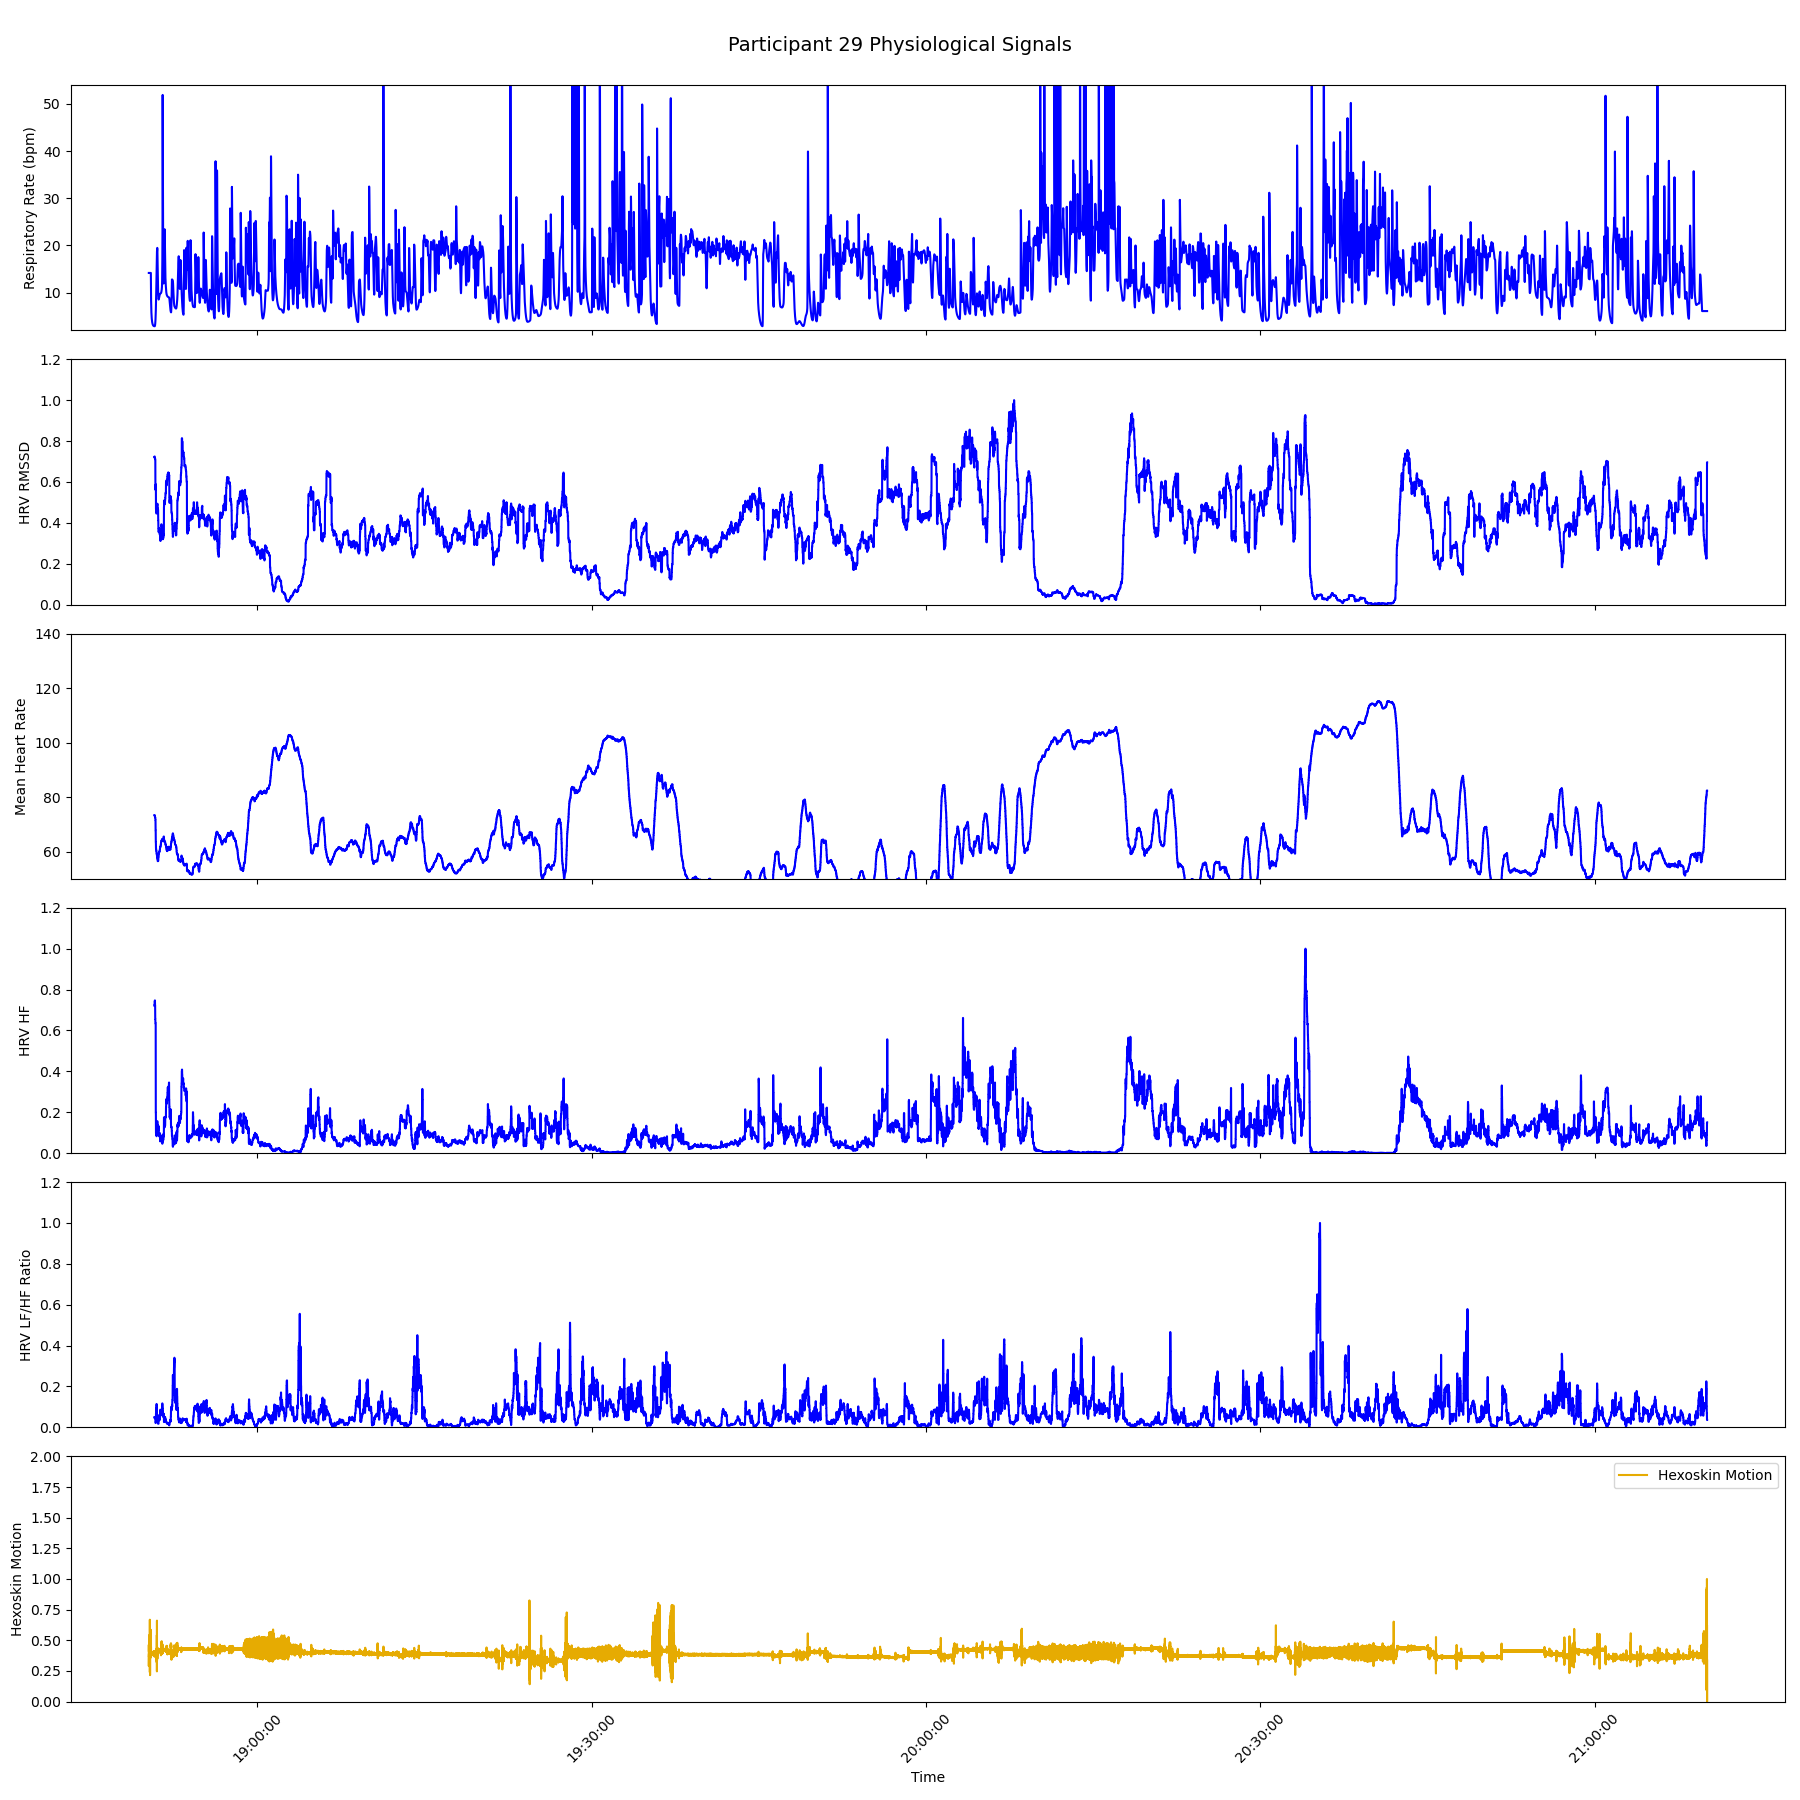

In [64]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd

import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_columns = scaler.fit_transform(signals[['hrv_lf_hf_ratio', 'hrv_hf', 'hrv_rmssd']])

scaled_df = pd.DataFrame(scaled_columns, columns=['hrv_lf_hf_ratio', 'hrv_hf', 'hrv_rmssd'], index=signals.index)

signals[['hrv_lf_hf_ratio', 'hrv_hf', 'hrv_rmssd']] = scaled_df


colors = mpl.colormaps['Dark2'].colors
signal_list = [
    'hrv_hf', 'hrv_mean_hr', 'hrv_lf_hf_ratio',
    'hrv_rmssd', 'Motion E4', 'Hexoskin Motion',
    'RSP_Rate', 'EDA_Tonic', 'EDA_Phasic'
]
signals_to_plot = [sig for sig in signals.columns if sig in signal_list]
motion_signals = ["Hexoskin Motion"]

num_rows = len(signals_to_plot) - len(motion_signals) + 1
fig, axes = plt.subplots(num_rows, 1, figsize=(18, 3 * num_rows), sharex=True)
axes = axes.flatten() if num_rows > 1 else [axes]

row_idx = 0
motion_trace_added = False

signal_labels = {
    'hrv_hf': 'HRV HF',
    'hrv_mean_hr': 'Mean Heart Rate',
    'hrv_lf_hf_ratio': 'HRV LF/HF Ratio',
    'hrv_rmssd': 'HRV RMSSD',
    'Hexoskin Motion': 'Hexoskin Motion',
    'RSP_Rate': 'Respiratory Rate (bpm)',

}

event_highlights = {
    "survey":      ("white", 0.0),
    "cycle_cal":   ("grey", 0.0),
    "matb_train":  ("grey", 0.4),
    "cycle":       ("purple", 0.4),
    "rest_1":      ("white", 0.0),
    "baseline":    ("turquoise", 0.5),
    "trial_1":     ("green", 0.4),
    "rest_2":      ("white", 0.0),
    "trial_2":     ("red", 0.4),
    "recovery":    ("white", 0.0),
}

y_limits = {
    'hrv_hf': (0, 1.2),
    'hrv_mean_hr': (50, 140),
    'hrv_lf_hf_ratio': (0, 1.2),
    'hrv_rmssd': (0, 1.2),
    'Hexoskin Motion': (0, 2),
    'RSP_Rate': (2, 54),
}

event_labels = {
    "survey":      "Survey",
    "cycle_cal":   "Calibration",
    "matb_train":  "Training",
    "cycle":       "Cycling",
    "rest_1":      "Rest 1",
    "baseline":    "Baseline",
    "trial_1":     "Trial 1",
    "rest_2":      "Resting 2",
    "trial_2":     "Trial 2",
    "recovery":    "Recovery"
}


motion_offset = 0.7
for idx, signal in enumerate(signals_to_plot):
    color = colors[idx % len(colors)]
    ax = axes[row_idx]
    label = signal_labels.get(signal, signal)

    if signal in motion_signals:
        if not motion_trace_added:
            ax.plot(signals.index, signals[signal], label=label, color=color)
            motion_trace_added = True
        else:
            ax.plot(signals.index, signals[signal] + motion_offset, label=f"{label}", color=color)
    else:
        ax.plot(signals.index, signals[signal], label=label, color='b')

    ax.set_ylabel(label)
    if signal in motion_signals:
        ax.legend(loc="upper right")

    if signal in y_limits:
        ax.set_ylim(y_limits[signal])

    row_idx += (1 if not (signal in motion_signals and motion_trace_added) else 0)

for ax in axes:
    for event_label, (color, alpha) in event_highlights.items():
        event_times = signals[signals["event"] == event_label].index
        if not event_times.empty:
            ax.axvspan(event_times[0], event_times[-1], color=color, alpha=alpha)

            ax.axvline(event_times[0], color="red", linestyle="--", linewidth=1)
            ax.axvline(event_times[-1], color="red", linestyle="--", linewidth=1)

            verbose_label = event_labels.get(event_label, event_label)
            ax.text(event_times[0], ax.get_ylim()[1], verbose_label, rotation=90,
                    verticalalignment="top", color="b", fontsize=12)



for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[-1].set_xlabel("Time")
fig.suptitle(f"Participant {participant_id} Physiological Signals", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(os.path.join(dataDirectory, "labeled_data.png"))
plt.show()

In [65]:
output_dir = '/home/art/SignalProcessing/Sessions/Summary'
os.makedirs(output_dir, exist_ok=True)

summary_stats = {'participant_id': participant_id}

all_stats = signals.describe().T[['mean']]  # only mean -AJS
for signal in all_stats.index:
    summary_stats[f'all_{signal}_mean'] = all_stats.loc[signal, 'mean']

for event in signals['event'].unique():
    df_event = signals[signals['event'] == event]
    event_stats = df_event.describe().T[['mean']] # only mean -AJS
    for signal in event_stats.index:
        summary_stats[f'{event}_{signal}_mean'] = event_stats.loc[signal, 'mean']

summary_stats_df = pd.DataFrame([summary_stats])


output_file = os.path.join(output_dir, 'summary_statistics_comparison.csv')

if os.path.exists(output_file):

    existing_data = pd.read_csv(output_file)
    combined_data = pd.concat([existing_data, summary_stats_df], ignore_index=True)
    combined_data.to_csv(output_file, index=False)
else:
    summary_stats_df.to_csv(output_file, index=False)

print(f"Summary statistics for Participant {participant_id} saved to {output_file}")

Summary statistics for Participant 29 saved to /home/art/SignalProcessing/Sessions/Summary/summary_statistics_comparison.csv
